<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

import copy



import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!

import random


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  Once I learned that it was a little less complicated to figure out how to slice and dice the image-datasets into mini-datasets with equal number of classes.

The second biggest after making a model and training it with the train and val datasets, was using the model to make predictions on the test set.  Unlike the train and validation sets I created, the test-set wouldn't be read by model.evaluate or model.predict.   Although this problem is at the very bottom of the jupyter notebook I tried to fix it here at the top.   About 100 stackoverflow examples later I think I got one [here](https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset)


Another problem that reoccurs is anytime I inadvertently want to mess with batch-size on the x_test dataset, I change the shapen from (None, 32, 32, 3) to (None, None, 32, 32, 3) and then it doesn't fit in model.evaluate() anymore.   I created a backup copy of x_test so I don't have to rerun the entire notebook each time.

In [2]:
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True)

dataset, x_test = dataset["train"], dataset["test"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


# believe I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

y_test = get_labels_from_tfdataset(x_test)



 # with_info = True, 
#If anything goes wrong, its because I added "as_supervised=True" to this above

dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
for img, label in dataset_dogs:
  assert label == 5
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0S2WPH/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0S2WPH/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


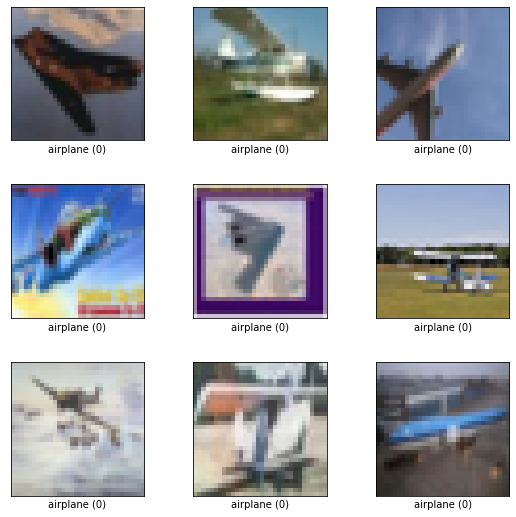

In [3]:
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

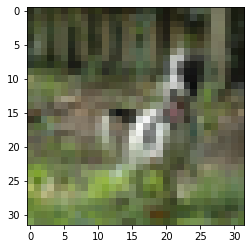

In [4]:
img, label = next(iter(dataset_dogs))

# print(img)
# plt.title(str(label))
plt.imshow(img)

# Get 1000 samples from each dataset class and create validation set

In [5]:
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
 
# print(val.cardinality())  # returns -2 
print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Now I need to split the remaining images of each data set in the remaining datasets into different training groups and
# mini_ds_airplanes = dataset_airplanes.skip(9)
# mini_ds_airplanes = mini_ds_airplanes.take(9)
# B = dataset_airplanes.shard(400, index=0)
# C = dataset_airplanes.shard(1000, index=1)
# list(B.as_numpy_iterator())
# list(C.as_numpy_iterator())
# mini_ds_airplanes
# plt.imshow(feature_dict['image'])
40000/16/10

tf.Tensor(10000, shape=(), dtype=int32)


250.0

# Create 16 small groups of training_sets: plan

The image below is a table of the planned training set divided into 16 groups of 250 images per class, resulting in each of the 16 groups named A through P, having a total of 2500 images each.  There are initially 16 groups, and then they are merged by 2s into 8 groups of 2s, and then 4 groups of 4, until they are merged for the 5th time into one large group of 16 groups, which is the original training set.  This grouping and division allows one to study 5 different image sizes, and the number per class is a relatively easy number to work with for reviewing the final confusion matrices resulting from each run.  Although there are many discrete mathematical combinations possible for combining the groups, this is not the focus of the study, the goal is to have a clear  data division that is repeatable and consistent throughout the test.   

 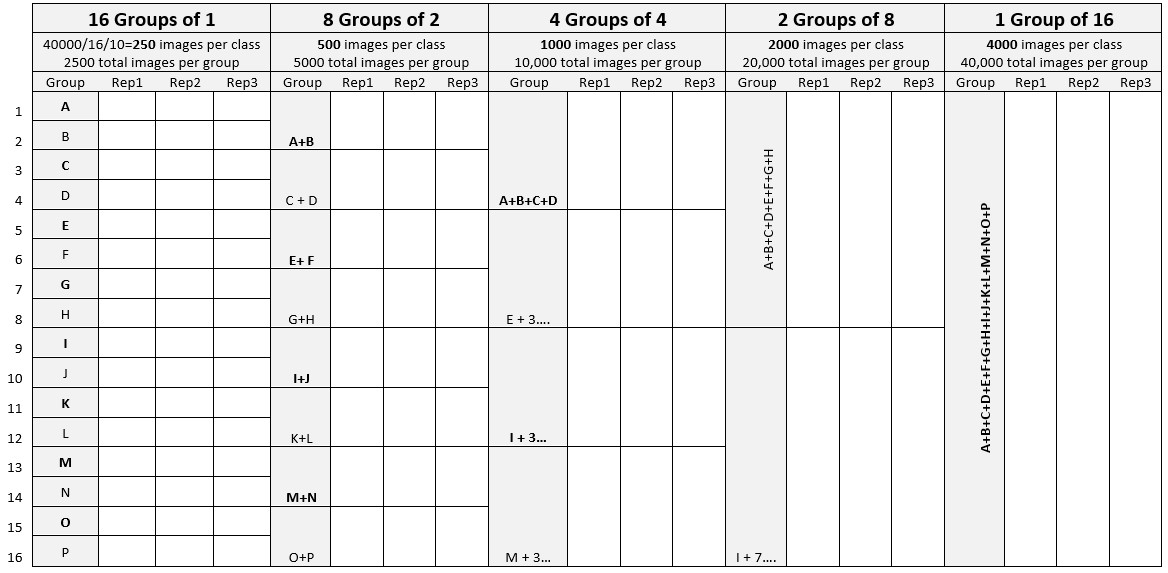

# Create 16 small groups of training_sets: implementation

The plan is to see if I can use shards to make the data division easy.   Can I just "shard" the remaining training set into 16 groups?

#### Airplanes (airplanes_A, ... airplanes_P)

In [6]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=16, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=16, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=16, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=16, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=16, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=16, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=16, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=16, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=16, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=16, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=16, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=16, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=16, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=16, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=16, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!







tf.Tensor(4000, shape=(), dtype=int32)
tf.Tensor(250, shape=(), dtype=int32)


#### Automobiles

In [7]:
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=16, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=16, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=16, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=16, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=16, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=16, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=16, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=16, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=16, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=16, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=16, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=16, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=16, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=16, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=16, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Birds

In [8]:
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=16, index = 0)
birds_B = dataset_birds.shard(num_shards=16, index = 1)
birds_C = dataset_birds.shard(num_shards=16, index = 2)
birds_D = dataset_birds.shard(num_shards=16, index = 3)
birds_E = dataset_birds.shard(num_shards=16, index = 4)
birds_F = dataset_birds.shard(num_shards=16, index = 5)
birds_G = dataset_birds.shard(num_shards=16, index = 6)
birds_H = dataset_birds.shard(num_shards=16, index = 7)
birds_I = dataset_birds.shard(num_shards=16, index = 8)
birds_J = dataset_birds.shard(num_shards=16, index = 9)
birds_K = dataset_birds.shard(num_shards=16, index = 10)
birds_L = dataset_birds.shard(num_shards=16, index = 11)
birds_M = dataset_birds.shard(num_shards=16, index = 12)
birds_N = dataset_birds.shard(num_shards=16, index = 13)
birds_O = dataset_birds.shard(num_shards=16, index = 14)
birds_P = dataset_birds.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Cats

In [9]:
# dataset_cats
 

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=16, index = 0)
cats_B = dataset_cats.shard(num_shards=16, index = 1)
cats_C = dataset_cats.shard(num_shards=16, index = 2)
cats_D = dataset_cats.shard(num_shards=16, index = 3)
cats_E = dataset_cats.shard(num_shards=16, index = 4)
cats_F = dataset_cats.shard(num_shards=16, index = 5)
cats_G = dataset_cats.shard(num_shards=16, index = 6)
cats_H = dataset_cats.shard(num_shards=16, index = 7)
cats_I = dataset_cats.shard(num_shards=16, index = 8)
cats_J = dataset_cats.shard(num_shards=16, index = 9)
cats_K = dataset_cats.shard(num_shards=16, index = 10)
cats_L = dataset_cats.shard(num_shards=16, index = 11)
cats_M = dataset_cats.shard(num_shards=16, index = 12)
cats_N = dataset_cats.shard(num_shards=16, index = 13)
cats_O = dataset_cats.shard(num_shards=16, index = 14)
cats_P = dataset_cats.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!



tf.Tensor(250, shape=(), dtype=int32)


#### Deer(s)

In [10]:
# dataset_deers

# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=16, index = 0)
deers_B = dataset_deers.shard(num_shards=16, index = 1)
deers_C = dataset_deers.shard(num_shards=16, index = 2)
deers_D = dataset_deers.shard(num_shards=16, index = 3)
deers_E = dataset_deers.shard(num_shards=16, index = 4)
deers_F = dataset_deers.shard(num_shards=16, index = 5)
deers_G = dataset_deers.shard(num_shards=16, index = 6)
deers_H = dataset_deers.shard(num_shards=16, index = 7)
deers_I = dataset_deers.shard(num_shards=16, index = 8)
deers_J = dataset_deers.shard(num_shards=16, index = 9)
deers_K = dataset_deers.shard(num_shards=16, index = 10)
deers_L = dataset_deers.shard(num_shards=16, index = 11)
deers_M = dataset_deers.shard(num_shards=16, index = 12)
deers_N = dataset_deers.shard(num_shards=16, index = 13)
deers_O = dataset_deers.shard(num_shards=16, index = 14)
deers_P = dataset_deers.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Dogs

In [11]:
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=16, index = 0)
dogs_B = dataset_dogs.shard(num_shards=16, index = 1)
dogs_C = dataset_dogs.shard(num_shards=16, index = 2)
dogs_D = dataset_dogs.shard(num_shards=16, index = 3)
dogs_E = dataset_dogs.shard(num_shards=16, index = 4)
dogs_F = dataset_dogs.shard(num_shards=16, index = 5)
dogs_G = dataset_dogs.shard(num_shards=16, index = 6)
dogs_H = dataset_dogs.shard(num_shards=16, index = 7)
dogs_I = dataset_dogs.shard(num_shards=16, index = 8)
dogs_J = dataset_dogs.shard(num_shards=16, index = 9)
dogs_K = dataset_dogs.shard(num_shards=16, index = 10)
dogs_L = dataset_dogs.shard(num_shards=16, index = 11)
dogs_M = dataset_dogs.shard(num_shards=16, index = 12)
dogs_N = dataset_dogs.shard(num_shards=16, index = 13)
dogs_O = dataset_dogs.shard(num_shards=16, index = 14)
dogs_P = dataset_dogs.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Frogs

In [12]:
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=16, index = 0)
frogs_B = dataset_frogs.shard(num_shards=16, index = 1)
frogs_C = dataset_frogs.shard(num_shards=16, index = 2)
frogs_D = dataset_frogs.shard(num_shards=16, index = 3)
frogs_E = dataset_frogs.shard(num_shards=16, index = 4)
frogs_F = dataset_frogs.shard(num_shards=16, index = 5)
frogs_G = dataset_frogs.shard(num_shards=16, index = 6)
frogs_H = dataset_frogs.shard(num_shards=16, index = 7)
frogs_I = dataset_frogs.shard(num_shards=16, index = 8)
frogs_J = dataset_frogs.shard(num_shards=16, index = 9)
frogs_K = dataset_frogs.shard(num_shards=16, index = 10)
frogs_L = dataset_frogs.shard(num_shards=16, index = 11)
frogs_M = dataset_frogs.shard(num_shards=16, index = 12)
frogs_N = dataset_frogs.shard(num_shards=16, index = 13)
frogs_O = dataset_frogs.shard(num_shards=16, index = 14)
frogs_P = dataset_frogs.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Horses

In [13]:
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=16, index = 0)
horses_B = dataset_horses.shard(num_shards=16, index = 1)
horses_C = dataset_horses.shard(num_shards=16, index = 2)
horses_D = dataset_horses.shard(num_shards=16, index = 3)
horses_E = dataset_horses.shard(num_shards=16, index = 4)
horses_F = dataset_horses.shard(num_shards=16, index = 5)
horses_G = dataset_horses.shard(num_shards=16, index = 6)
horses_H = dataset_horses.shard(num_shards=16, index = 7)
horses_I = dataset_horses.shard(num_shards=16, index = 8)
horses_J = dataset_horses.shard(num_shards=16, index = 9)
horses_K = dataset_horses.shard(num_shards=16, index = 10)
horses_L = dataset_horses.shard(num_shards=16, index = 11)
horses_M = dataset_horses.shard(num_shards=16, index = 12)
horses_N = dataset_horses.shard(num_shards=16, index = 13)
horses_O = dataset_horses.shard(num_shards=16, index = 14)
horses_P = dataset_horses.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Ships

In [14]:
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=16, index = 0)
ships_B = dataset_ships.shard(num_shards=16, index = 1)
ships_C = dataset_ships.shard(num_shards=16, index = 2)
ships_D = dataset_ships.shard(num_shards=16, index = 3)
ships_E = dataset_ships.shard(num_shards=16, index = 4)
ships_F = dataset_ships.shard(num_shards=16, index = 5)
ships_G = dataset_ships.shard(num_shards=16, index = 6)
ships_H = dataset_ships.shard(num_shards=16, index = 7)
ships_I = dataset_ships.shard(num_shards=16, index = 8)
ships_J = dataset_ships.shard(num_shards=16, index = 9)
ships_K = dataset_ships.shard(num_shards=16, index = 10)
ships_L = dataset_ships.shard(num_shards=16, index = 11)
ships_M = dataset_ships.shard(num_shards=16, index = 12)
ships_N = dataset_ships.shard(num_shards=16, index = 13)
ships_O = dataset_ships.shard(num_shards=16, index = 14)
ships_P = dataset_ships.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


#### Trucks


In [15]:
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=16, index = 0)
trucks_B = dataset_trucks.shard(num_shards=16, index = 1)
trucks_C = dataset_trucks.shard(num_shards=16, index = 2)
trucks_D = dataset_trucks.shard(num_shards=16, index = 3)
trucks_E = dataset_trucks.shard(num_shards=16, index = 4)
trucks_F = dataset_trucks.shard(num_shards=16, index = 5)
trucks_G = dataset_trucks.shard(num_shards=16, index = 6)
trucks_H = dataset_trucks.shard(num_shards=16, index = 7)
trucks_I = dataset_trucks.shard(num_shards=16, index = 8)
trucks_J = dataset_trucks.shard(num_shards=16, index = 9)
trucks_K = dataset_trucks.shard(num_shards=16, index = 10)
trucks_L = dataset_trucks.shard(num_shards=16, index = 11)
trucks_M = dataset_trucks.shard(num_shards=16, index = 12)
trucks_N = dataset_trucks.shard(num_shards=16, index = 13)
trucks_O = dataset_trucks.shard(num_shards=16, index = 14)
trucks_P = dataset_trucks.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


tf.Tensor(250, shape=(), dtype=int32)


# Merge 1/16th of each CIFAR Training Datasets into 16 Small training Groups {A}, {B}, {C} , ... {P}

#### Group A  (train_A)

In [16]:
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i)

print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 


tf.Tensor(2500, shape=(), dtype=int32)


#### Group B

In [17]:
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [18]:
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [19]:
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [20]:
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [21]:
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [22]:
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [23]:
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [24]:
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [25]:
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

# The following groups were eliminated to reduce run time

#### Group K (commented out)

In [26]:
# # {K}
# X = birds_K, cats_K, deers_K, dogs_K, frogs_K, horses_K, ships_K, trucks_K
# train_K = airplanes_K.concatenate(automobiles_K)

# for i in list(X):
#   train_K = train_K.concatenate(i)

# # print(train_K.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group L (commented out)

In [27]:
# # {L}
# X = birds_L, cats_L, deers_L, dogs_L, frogs_L, horses_L, ships_L, trucks_L
# train_L = airplanes_L.concatenate(automobiles_L)

# for i in list(X):
#   train_L = train_L.concatenate(i)

# # print(train_L.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group M (commented out)

In [28]:
# # {M}
# X = birds_M, cats_M, deers_M, dogs_M, frogs_M, horses_M, ships_M, trucks_M
# train_M = airplanes_M.concatenate(automobiles_M)

# for i in list(X):
#   train_M = train_M.concatenate(i)

# # print(train_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group N (commented out)

In [29]:
# # {N}
# X = birds_N, cats_N, deers_N, dogs_N, frogs_N, horses_N, ships_N, trucks_N
# train_N = airplanes_N.concatenate(automobiles_N)

# for i in list(X):
#   train_N = train_N.concatenate(i)

# # print(train_N.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group O (commented out)

In [30]:
# # {O}
# X = birds_O, cats_O, deers_O, dogs_O, frogs_O, horses_O, ships_O, trucks_O
# train_O = airplanes_O.concatenate(automobiles_O)

# for i in list(X):
#   train_O = train_O.concatenate(i)

# # print(train_O.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group P (commented out)

In [31]:
# # {P}
# X = birds_P, cats_P, deers_P, dogs_P, frogs_P, horses_P, ships_P, trucks_P
# train_P = airplanes_P.concatenate(automobiles_P)

# for i in list(X):
#   train_P = train_P.concatenate(i)

# # print(train_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

# Test whether I can train a model on just Group A

## Create a copy of validation and train_A since I keep messing with the shape and batch size


In [32]:
 
val_copy = copy.copy(val)
train_A_copy = copy.copy(train_A)

# deepcopy results in "TypeError: can't pickle _thread.RLock objects"

### Set Random Seeds

In [33]:
##  Random Seed
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
## ------------------

I will now see if I can use the small group A train set, the val set, and the test set of the CIFAR-10 using a vanilla CNN

In [34]:
# train_A_example = train_A.take(250)
# for sample in train_A_example:
#     image,label = sample['image'].numpy(), sample["label"].numpy()
#     plt.imshow(image[:,:,:].astype(np.uint8))
#     plt.show()
#     print("Label: %d" % label)

In [35]:
# I already have train_A ... P and val, I will eventually need test set.
# remember that train_A and val are NOT shuffled at all



# https://www.tensorflow.org/tutorials/load_data/images#train_a_model says
# Configure the dataset for performance
# Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:
# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
# Dataset.prefetch overlaps data preprocessing and model execution while training.


val = val_copy
train_A = train_A_copy




# # I don't know if below works - I could check by running with and without it
AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
train_A = train_A.shuffle(1000, reshuffle_each_iteration=False, seed=seed)
train_A = train_A.batch(100)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure


val = val.cache().prefetch(buffer_size=AUTOTUNE)
val = val.batch(100)


# Everything Below Is My Attempt to Reconvert the TF Tensor to Array to work "as usual" but it continued to fail because I couldn't get shape right
# Now I'm moving forward using the default TF Tensor Shape instead of numpy array, and finding I need to set a lot of parameters I took for granted like...
# batch, cache, and prefetch

  # # The below doesn't work because it doesn't recognize train_A as  a dataset
  # # "ValueError: Attempt to convert a value (<PrefetchDataset shapes: ((32, 32, 3), ()),
  # # types: (tf.uint8, tf.int64)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>) to a Tensor."
  # # train_A.batch(32)

#I can no longer run image_batch.shape,  Attempt to convert a value (<ShuffleDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.uint8, tf.int64)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>) to a Tensor.
# tf.shape(train_A)

# After Batching I can no onger run the following for loop to get image_batch.shape
# InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [128,32,32,3] and element 19 had shape [68,32,32,3]. [Op:IteratorGetNext]
# for image_batch, labels_batch in train_A:
#   print(image_batch.shape)   # (32, 32, 3)  <-- the first number is missing, should be a batch size like (64, 32, 32, 3)
#   print(labels_batch.shape)  # ()   <-  that's bad , it should be a number that matches a batch size like 64
#   break



train_A.element_spec
  # # Returns two specs.
  # # (TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None),
  # # TensorSpec(shape=(), dtype=tf.int64, name=None))
  # #

  # # class_names = train_A.class_names
  # # print(class_names)


  

  # # changing to a numpy array takes time, I wish it was faster, or i wish i could keep as tensor
  # y_train = np.array([])
  # x_val = np.array([])
  # y_val = np.array([])

  # # x_train = np.expand_dims(x_train, -1)
  # # x_val = np.expand_dims(x_val, -1)

  # for images, labels in train_A.take(1):  # only take first element of dataset
  #     # x_train = np.empty((images.numpy()).shape, dtype=np.int64)
  #     # y_train = np.empty((labels.numpy()).shape,  dtype=np.int64)
  #     x_train = images.numpy()
  #     y_train = labels.numpy()

  #     # y_train = labels.numpy()

  # x_train = []  #images
  # y_train = []  #labels
  # for i, (image, label) in enumerate(tfds.as_numpy(train_A)):  # only take first element of dataset
  #     x_train.append(image)
  #     y_train.append(labels)

  

  # x_val = []
  # y_val = []
  # for i, (image, label) in enumerate(tfds.as_numpy(val)):  # only take first element of dataset
  #     # x_val = images.numpy() #32, 32, 3
  #     # y_val = labels.numpy()  #()
  #     x_val.append(image)
  #     y_val.append(label)
  
  

  # # #x_test = np.expand_dims(x_test, -1)

  # num_classes = 10


  # # # convert class vectors to binary class matrices
  # y_train = tf.keras.utils.to_categorical(y_train, num_classes)
  # y_val   = tf.keras.utils.to_categorical(y_val, num_classes)
  # #y_test = keras.utils.to_categorical(y_test, num_classes)


  # # x_val = tf.stack(x_val)
  # # y_val = tf.stack(y_val)


(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 15, 15, 32)        0         
_________________________________________________________________
BN1 (BatchNormalization)     (None, 15, 15, 32)        128       
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 6, 6, 64)          0         
_________________________________________________________________
BN2 (BatchNormalization)     (None, 6, 6, 64)          2

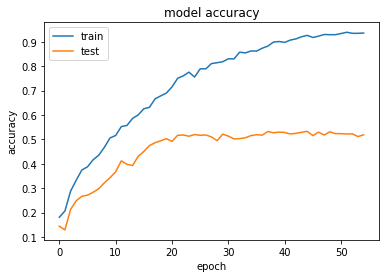

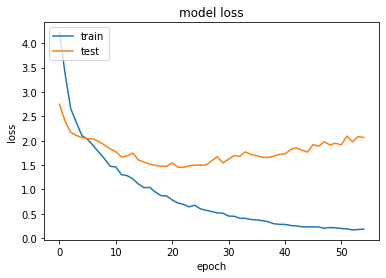

In [36]:
# Make a Vanilla CNN
num_classes = 10
input_shape = (32, 32, 3)

# For Reference these are the defaults
# kernel_initializer="glorot_uniform",
# bias_initializer="zeros",
# padding="valid",  #valid = no padding
# kernel_regularizer=None,
# bias_regularizer=None,
# activity_regularizer=None,

initializer = tf.keras.initializers.HeUniform(seed)

model = tf.keras.Sequential(
[
    #keras.Input(),
    tf.keras.Input(shape=input_shape),

    layers.experimental.preprocessing.Rescaling(1./255),
    #data_augmentation,   
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
    layers.BatchNormalization(name="BN1"),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
    layers.BatchNormalization(name="BN2"),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
    layers.BatchNormalization(name="BN3"),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu", kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")

])

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history = model.fit(
  train_A,
  validation_data=(val),
  epochs=100,
  callbacks = keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=10, restore_best_weights=True, verbose=2),
)

 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
!mkdir -p saved_model
model.save('saved_model/my_model')

# new_model = tf.keras.models.load_model('saved_model/my_model')

# # Check its architecture
# new_model.summary()

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Evaluate Model on Test Set

In [38]:
# model.predict(x_test) fails with error:
# WARNING:tensorflow:Model was constructed with shape (None, 32, 32, 3) for...\
#   input KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), 
#   name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (32, 32, 3).
#   so I think I need to give it "batch" sizes 


# # # I don't know if below works - I could check by running with and without it
# AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
# x_test = x_test.cache().prefetch(buffer_size=AUTOTUNE)
# # x_test = x_test.shuffle(10000, reshuffle_each_iteration=False)
# x_test = x_test.batch(1000)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure

 
print("Y_test : ", y_test)
print("X_test : ", x_test)
print("TrainA : ", train_A)

# test_images = list(map(lambda x: x[0], x_test))
# y_test = list(map(lambda x: x[1], x_test))

# The problem with https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model i
# is it doesn't explain how to use a model.evaluate function with tfds.load()
# x_test = x_test.num_parallel_calls(tf.data.AUTOTUNE)  # AttributeError: 'PrefetchDataset' object has no attribute 'num_parallel_calls'
x_test = x_test.batch(10000)
x_test = x_test.cache()
x_test = x_test.prefetch(tf.data.AUTOTUNE)

model.evaluate(x_test, verbose=2)
## WORKED!!!!!!!!!!!!!!!!!!!!!!!
# 79/79 - 1s - loss: 1.4953 - accuracy: 0.5314
# [1.4952507019042969, 0.5314000248908997]


Y_test :  tf.Tensor([7 0 6 ... 8 6 0], shape=(10000,), dtype=int64)
X_test :  <PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
TrainA :  <BatchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.uint8, tf.int64)>
1/1 - 1s - loss: 1.7575 - accuracy: 0.5391


[1.7574964761734009, 0.5390999913215637]

At an earlier date  the accuracy of model.evaluate is 0.5314

Oct 19 2020 1:06 PM the accuracy of model.evaluate is 0.5312

Oct 19 2020 1:14 PM the accuracy of model.evaluate is 0.5365

Oct 19 2020 1:14 PM the accuracy of model.evaluate is 0.5294

Oct 20 2020 10:27 AM the accuracy of model.evaluate is 0.512  noticed that it didnt have early stopping so bumped up epochs to 100 from 50 

Also added a "seed" assignment to this line:  should help reduce the variance.  train_A.shuffle(1000, reshuffle_each_iteration=True, seed=seed)


Otc 20 at 10:38 AM  test accuracy of 0.5376

Oct 20 at 10:40 AM test accuracy of 0.5329

0.53289

[[486  57  81  16  26  25  16  14 211  68]
 [ 28 651  15   6   8  17  11  10  87 167]
 [ 79  10 350  65 141 128 105  65  33  24]
 [ 20  11  79 263 109 264  98  72  48  36]
 [ 36  10  66  43 511  66  71 141  37  19]
 [ 16   5  65 126  67 545  34 100  13  29]
 [ 19  10  63  39 102  50 646  22  13  36]
 [ 28  13  44  39  58 133   8 625   8  44]
 [ 94  56  12  15  15  15  11  10 694  78]
 [ 35 136  24  21  17  16  24  28  79 620]]


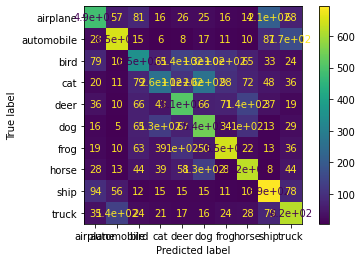

In [39]:


 
# print(y_test)  # 1 column? of actual labels.
y_pred = model.predict(x_test)
# print(y_pred)  # 10 columns? of softmax
# I need to convert this large y_pred of continuous probabilities into a 1-coded label vectors
y_pred_1hot = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )  #doesnt run because
# alueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets
# WORKS NOW


disp = ConfusionMatrixDisplay(cm, display_labels=['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']).plot()

print(cm)

## Confusion Matrix of Cats

I wanted to verify the confusion matrix was working, so I sent just `cats_A`, through the predictive model.  I figured out that scikits `confusion_matrix` only saw and used the numerical values from the prediction and that's why it looked like it was skipping an index.  Thanks [SO](https://stackoverflow.com/questions/35162652/construct-confusion-matrix-with-missing-data)  

In [40]:
cats_A = cats_A.batch(250)

In [41]:
# # print(y_test)  # 1 column? of actual labels.



preds_cats = model.predict(cats_A)
# # print(y_pred)  # 10 columns? of softmax
# # I need to convert this large y_pred of continuous probabilities into a 1-coded label vectors
preds_cats = np.argmax(preds_cats, axis=1)


# # print(preds_cats)  #- lots of threes predicted which is good
# # [3 3 3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 2 3 3 3 4 3 3 3 3 6 3 3 3 3 3 3 3 3
# #  3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3
# #  6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 6 4 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 3 3 3 3 3 3 3 3 3 6 4 3 3 3 2 3 3 3 3
# #  3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

# # np.unique(preds_cats)
# #I need y_true or "cat_true", which is cat_A labels, to be defined here as an eagertensor, like it was for y_test, so I guess I should define it hte same way I defined y_test

y_cats = get_labels_from_tfdataset(cats_A)

# # print(y_cats)  # Printsa tf.Tensor of 3s (250 of them) which is correct
# # # tf.Tensor(
# # [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(250,), dtype=int64)

# # so Im guessing that means my confusion matrix index starts at 1 and misses class 0
# cm2 = confusion_matrix(y_true = y_cats, y_pred = preds_cats , labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  #doesnt run because
# # alueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets
# # WORKS NOW
# print(cm2)

# disp2 = ConfusionMatrixDisplay(cm2, display_labels= ['airplane',
#  'automobile',
#  'bird',
#  'cat',
#  'deer',
#  'dog',
#  'frog',
#  'horse',
#  'ship',
#  'truck']).plot()

Now I see cats are most commonly predicted to be dogs.  I want to highlight and show the pictures of the Cats that were predicted to be Dogs, and perhaps, show the pictures of Cats that are predicted to be Cats

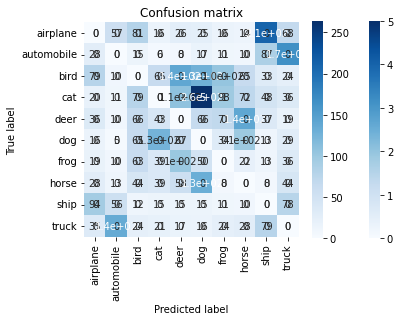

In [42]:
CLASSES = info.features['label'].names

def show_confusion_matrix(test_labels, predictions, CLASSES):
  """Compute confusion matrix and normalize."""
  confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  
  
  confusing_part_matrix= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)
  
  # print(confusion)
  # print(confusion.astype("float"))
  # print(confusion.sum(axis=1))
  # # confusion_normalized = np.divide(confusion.astype("float"), confusion.sum(axis=1))
  # confusion_normalized = np.where(confusing_part_matrix> 0, np.divide(confusing_part_matrix.astype("float"), confusing_part_matrix.sum(axis=1)), 0)
  axis_labels = CLASSES
  # ax = sns.heatmap(
  #     confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
  #     cmap='Blues', annot=True, fmt='.2f', square=True)
  ax = sns.heatmap(
      confusing_part_matrix, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, square=True)

  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

 
show_confusion_matrix(y_cats, preds_cats, CLASSES = CLASSES)

# confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

In [83]:
# fig = tfds.show_examples(tf.data.Dataset.unbatch(cats_A), info)

# I want to identify images that wer not predicted as cats
errors = ( preds_cats - 3 !=0 )  # IF predicted class is 3, then a correct prediction yields 3-3 = 0.  

#print(errors) # this prints the answer to 250 questions, I just want the index of the wrong ones with respect to the 250

index, = np.where(errors == True)
print(index)

 

[ 17  36  39 113 153 176]


In [97]:
 
# # Continued attempt to view the wrong classified images
# # https://stackoverflow.com/questions/66410340/filter-tensorflow-dataset-by-id

# Rebuilding Toy Exampe from stackover flow
m_X_ds = tf.data.Dataset.from_tensor_slices(list(range(1, 21))).shuffle(10, reshuffle_each_iteration=False)
arr = np.array([3, 4, 5])

# Option A
m_X_ds = list(m_X_ds)  # Load into memory.
m_X_ds = tf.gather(m_X_ds, arr) # Gather as usual.
print(m_X_ds)  
# Example result: <tf.Tensor: shape=(3,), dtype=int32, numpy=array([8, 6, 2], dtype=int32)>


# -----------------------
# So I want to get cats_A_ids and arr = errors

new_index  = np.array([17,  36,  39, 113, 153, 176])

cats_A_wrong = list(tf.data.Dataset.unbatch(cats_A))
cats_A_wrong = tf.gather(cats_A_wrong, new_index)
print(cats_A_wrong)

tf.Tensor([ 5 11  3], shape=(3,), dtype=int32)


InvalidArgumentError: ignored

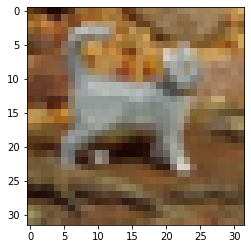

In [118]:
# ## Attempt 3001
# #https://stackoverflow.com/questions/41135302/how-to-display-a-misclassified-image
# # 
# # computation graph
# predictions = argmax(softmax(final_layer))
# matches = predictions == argmax(labels) # if one-hot encoded

# # later
# batch_matches = sess.run(matches, feed_dict={...})

# for image, does_match in zip(batch_images, batch_matches):
#   if not does_match:
#     cv2.imwrite('mismatched.png', image)

# Attempt 3004
img, label = next(iter(cats_A_wrong))  #just unbatched cats_A for now, not really wrong

# print(img)
# plt.title(str(label))
plt.imshow(img)

In [113]:
# fnames = cats_A.image ## fnames is all the filenames/samples used in testing
#errors = np.where(y_pred != test_generator.classes)[0] ## misclassifications done on the test data where y_pred is the predicted values
# for i in errors:
#     print(fnames[i])

# # for i in cats_A.enumerate
# #   where(i == arr)
cats_A.info.splits.keys()

builder.info.splits['train'].num_examples  # 10_000
builder.info.splits['train[:75%]'].num_examples  # 7_500 (also works with slices)
builder.info.splits.keys()  # ['train', 'test']

AttributeError: ignored